# Triple-Halide Perovskites: Contour Map
KB 2022-01-02

In [1]:
## Load packages
import grama as gr
import numpy as np
import plotnine as pt

## Load scikit tools
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

## Package setup
DF = gr.Intention()

In [2]:
## Barycentric converter
def tran_bary(df):
    r"""Convert to barycentric coordinates
    """
    df_tmp = df.copy()
    df_tmp["x"] = 0.0 * df.I + 1.0 * df.Br + 0.5 * df.Cl
    df_tmp["y"] = 0.0 * df.I + 0.0 * df.Br + np.sqrt(1 - 0.5**2) * df.Cl
    
    return df_tmp

# Pipe-enabled function
tf_bary = gr.add_pipe(tran_bary)
# Triangle boundary
df_tri_bounds = (
    gr.df_make(
        Br=[1, 0, 0, 1],
        Cl=[0, 1, 0, 0],
        I =[0, 0, 1, 0],
    )
    >> tf_bary()
)
# Labels
df_tri_labels = (
    gr.df_make(
        x=[-0.1, +1.1, +0.5],
        y=[+0.0, +0.0, +np.sqrt(1 - 0.5**2) + 0.1],
        label=["I", "Br", "Cl"]
    )
)

# Generate Example Data

In [3]:
## Fake Triple Halide Perovskite data: 
df_thp_1 = (
    ## I -- Br tie
    gr.df_make(
        Br=np.linspace(0, 1, num=6),
        Cl=0,
        single_phase=True,
    )
    >> gr.tf_mutate(I=1 - DF.Br)
    
    ## Cl -- Br tie
    >> gr.tf_bind_rows(
        gr.df_make(
            Br=np.linspace(0, 0.99, num=6),
            I=0,
            single_phase=True,
        )
    >> gr.tf_mutate(Cl=1 - DF.Br)
    )    
    ## I -- Cl tie
    >> gr.tf_bind_rows(
        gr.df_make(
            Cl =np.linspace(0.1, 0.9, num=5),
            Br =0,
            single_phase=False,
        )
    >> gr.tf_mutate(I= 1 - DF.Cl)
    )    
    ## Middle of Cl -- I
    # Replicate single point to weight against densely-sampled edges
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.33, I=0.33, Br=[0.34] * 1, single_phase=False)
    )
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.10, I=0.40, Br=[0.50] * 1, single_phase=False)
    )
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.80, I=0.10, Br=[0.10] * 1, single_phase=True)
    )
    >> tf_bary()
)

# Visualize Data

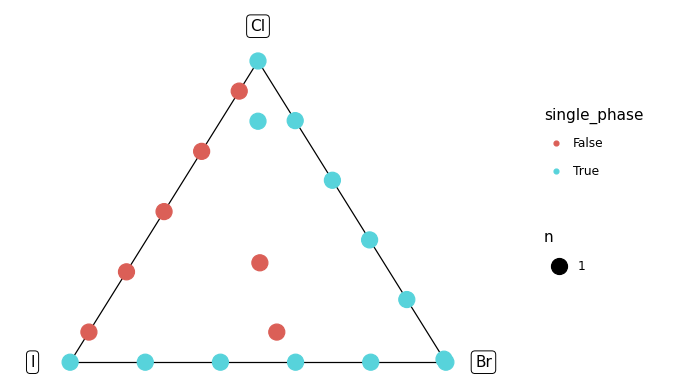

<ggplot: (179570181105)>

In [4]:
#Select data to display:
df_thp = df_thp_1

#Show visualization
(
    df_thp
    
    >> pt.ggplot(pt.aes("x", "y"))
    + pt.geom_segment(
        data=df_tri_bounds,
        mapping=pt.aes(xend="gr.lead(x)", yend="gr.lead(y)")
    )
    + pt.geom_label(
        data=df_tri_labels,
        mapping=pt.aes(label="label")
    )
    + pt.geom_count(pt.aes(color="single_phase"))
    + pt.theme_void()
    + pt.theme(
        plot_background=pt.element_rect(fill="white")
    )
)

# Make Gaussian Process Model
Train the model

In [5]:
## Set up training data
var = ["Cl", "Br", "I"]
out = ["single_phase"]
df_train = (
    df_thp
)
X = df_train[var]
Y = np.atleast_2d(df_train[out].values)

## Fit a GP
kernel = 1.0 * RBF(1.0)
model_gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(X, Y)

# Package the model
md_gpc = (
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            pr_single_phase=model_gpc.predict_proba(df[var])[:, 1]
        ),
        var=var,
        out=["pr_single_phase"]
    )
)

Display model in barycentric coordinates

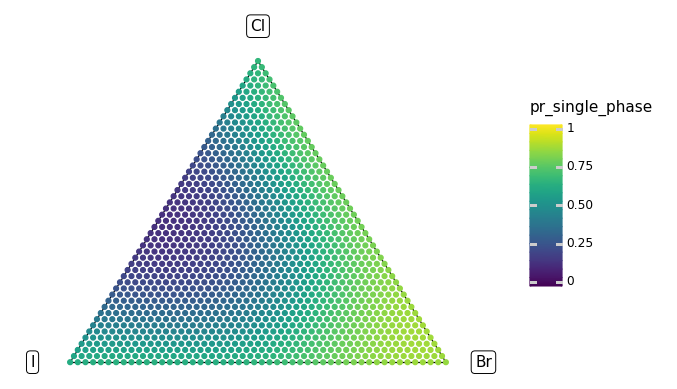

<ggplot: (179570214361)>

In [6]:
(
    gr.df_make(Br=np.linspace(0, 1, num=50))
    >> gr.tf_outer(
        df_outer=gr.df_make(Cl=np.linspace(0, 1, num=50))
    )
    >> gr.tf_filter(DF.Br + DF.Cl <= 1)
    >> gr.tf_mutate(I=1 - DF.Br - DF.Cl)
    >> tf_bary()
    >> gr.tf_md(md_gpc)
    >> gr.tf_mutate(pr_log=gr.log(DF.pr_single_phase))
    
    >> pt.ggplot(pt.aes("x", "y"))
    + pt.geom_segment(
        data=df_tri_bounds,
        mapping=pt.aes(xend="gr.lead(x)", yend="gr.lead(y)")
    )
    + pt.geom_label(
        data=df_tri_labels,
        mapping=pt.aes(label="label")
    )
    + pt.geom_point(pt.aes(color="pr_single_phase"))
    
    + pt.scale_color_continuous(limits=(0, 1))
    + pt.theme_void()
    + pt.theme(
        plot_background=pt.element_rect(fill="white")
    )
)

# Make Contour Map

In [7]:
gr.eval_contour()

<function eval_contour at 0x0000029CEEE365E0>

In [8]:
#pip install -U py-grama

In [13]:
(
gr.Model()
>> gr.cp_vec_function(
    fun=lambda df: gr.df_make(
    f=df_thp[Br],
    g=df.x + df.y,),
    
    var=["x", "y"],
    out=["f", "g"],
    )
    
>> gr.cp_bounds(
    x=(-1, +1),
    y=(-1, +1),
    )
    
>> gr.ev_contour(
    var=["x", "y"],
    out=["f", "g"],
    )

>> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_segment(gr.aes(xend="x_end", yend="y_end", group="level", color="out"))
)

    

NameError: name 'Br' is not defined

In [ ]:
>>> ## Auxiliary inputs
    >>> (
    >>>     gr.Model()
    >>>     >> gr.cp_vec_function(
    >>>         fun=lambda df: gr.df_make(
    >>>             f=df.c * df.x + (1 - df.c) * df.y,
    >>>         ),
    >>>         var=["x", "y"],
    >>>         out=["f", "g"],
    >>>     )
    >>>     >> gr.cp_bounds(
    >>>         x=(-1, +1),
    >>>         y=(-1, +1),
    >>>     )
    >>>     >> gr.ev_contour(
    >>>         var=["x", "y"],
    >>>         out=["f"],
    >>>         df=gr.df_make(c=[0, 1])
    >>>     )
    >>>
    >>>     >> gr.ggplot(gr.aes("x", "y"))
    >>>     + gr.geom_segment(gr.aes(xend="x_end", yend="y_end", group="level", color="c"))
    >>> )